### **Dự án: House Price Prediction using Real Estate Data**

#### Kỹ thuật áp dụng:

* **Regression** (Linear and Tree-based)
* **Model Evaluation** (MSE, R², Cross-validation)

#### Mô tả:

Tạo một mô hình dự đoán giá thuê nhà dựa trên các đặc trưng như: diện tích, số phòng, khu vực, tiện nghi, thời gian xây dựng, v.v.


### Đọc dữ liệu

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

print("Các thư viện đã được import thành công!")

Các thư viện đã được import thành công!


In [37]:
try:
    df = pd.read_csv('/content/train.csv') #https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=train.csv
    print("Đọc dữ liệu thành công!")
    print(df.head())
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file train.csv.")

Đọc dữ liệu thành công!
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice

### **Initial Exploratory Data Analysis - EDA**

1.  **Thông tin chung về DataFrame:** Số lượng hàng và cột, kiểu dữ liệu của từng cột, số lượng giá trị non-null.
2.  **Thống kê mô tả:** Các giá trị thống kê như trung bình, độ lệch chuẩn, giá trị nhỏ nhất, giá trị lớn nhất, các (quartiles) cho các cột số.
3.  **Phân bố của biến mục tiêu (SalePrice):** Xem xét phân bố của giá nhà để hiểu liệu nó có bị lệch (skewed) hay không.
4.  **Kiểm tra giá trị thiếu (Missing Values):** Xác định các cột có


Thông tin DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   

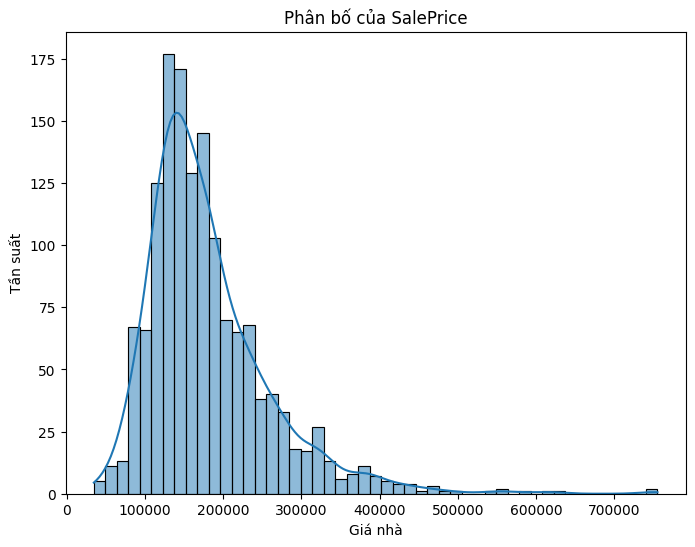


Số lượng giá trị thiếu trong mỗi cột:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


In [38]:
# Thông tin chung về DataFrame
print("Thông tin DataFrame:")
df.info()

print("\nThống kê mô tả các cột số:")
print(df.describe())

# Phân bố của biến mục tiêu (SalePrice)
plt.figure(figsize=(8, 6))
sns.histplot(df['SalePrice'], kde=True)
plt.title('Phân bố của SalePrice')
plt.xlabel('Giá nhà')
plt.ylabel('Tần suất')
plt.show()

# Kiểm tra giá trị thiếu
missing_values = df.isnull().sum().sort_values(ascending=False)
print("\nSố lượng giá trị thiếu trong mỗi cột:")
print(missing_values[missing_values > 0]) # Chỉ hiển thị các cột có giá trị thiếu

### Tiền xử lý dữ liệu

Dựa trên ý nghĩa và tỷ lệ giá trị thiếu, chúng ta sẽ quyết định nên loại bỏ cột, điền giá trị, hay giữ nguyên (trong một số trường hợp, giá trị thiếu có thể mang thông tin).

In [39]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage = missing_percentage.sort_values(ascending=False)
print("Tỷ lệ phần trăm giá trị thiếu trong mỗi cột:")
print(missing_percentage[missing_percentage > 0])

Tỷ lệ phần trăm giá trị thiếu trong mỗi cột:
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageQual       5.547945
GarageFinish     5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


Do tỷ lệ phần trăm quá cao nên việc loại bỏ có thể ảnh hưởng đến mô hình nên ta thêm cột binary để tránh thiếu sót thông tin

In [40]:
# Tạo cột HasPool và điền giá trị thiếu của PoolQC
df['HasPool'] = df['PoolQC'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['PoolQC'] = df['PoolQC'].fillna('NoPool')

# Tạo cột HasMiscFeature và điền giá trị thiếu của MiscFeature
df['HasMiscFeature'] = df['MiscFeature'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['MiscFeature'] = df['MiscFeature'].fillna('None')

# Tạo cột HasAlley và điền giá trị thiếu của Alley
df['HasAlley'] = df['Alley'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['Alley'] = df['Alley'].fillna('NoAlley')

# Tạo cột HasFence và điền giá trị thiếu của Fence
df['HasFence'] = df['Fence'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['Fence'] = df['Fence'].fillna('NoFence')

# Tạo cột HasFireplace và điền giá trị thiếu của FireplaceQu
df['HasFireplace'] = df['FireplaceQu'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['FireplaceQu'] = df['FireplaceQu'].fillna('NoFireplace')

# Kiểm tra lại số lượng giá trị thiếu sau khi xử lý
missing_values_updated = df.isnull().sum().sort_values(ascending=False)
print("Số lượng giá trị thiếu sau bước xử lý đầu tiên:")
print(missing_values_updated[missing_values_updated > 0].head(10))

Số lượng giá trị thiếu sau bước xử lý đầu tiên:
MasVnrType      872
LotFrontage     259
GarageCond       81
GarageFinish     81
GarageType       81
GarageQual       81
GarageYrBlt      81
BsmtFinType2     38
BsmtExposure     38
BsmtQual         37
dtype: int64


In [41]:
# Tính giá trị trung vị của cột LotFrontage
median_lotfrontage = df['LotFrontage'].median()

# Điền các giá trị thiếu trong cột LotFrontage bằng giá trị trung vị
df['LotFrontage'] = df['LotFrontage'].fillna(median_lotfrontage)

# Kiểm tra lại số lượng giá trị thiếu của cột LotFrontage
print(f"Số lượng giá trị thiếu trong cột LotFrontage sau khi điền: {df['LotFrontage'].isnull().sum()}")

Số lượng giá trị thiếu trong cột LotFrontage sau khi điền: 0


**Lý do tại sao mode thường được sử dụng cho biến phân loại:**

Duy trì tính toàn vẹn của dữ liệu: Khác với các biến số, chúng ta không
thể tính trung bình hoặc trung vị một cách có ý nghĩa cho các danh mục.

Việc điền bằng một danh mục mới có thể làm sai lệch phân phối của biến

Giả định hợp lý: Điền bằng mode dựa trên giả định rằng giá trị xuất hiện nhiều nhất có khả năng là giá trị phù hợp nhất để thay thế cho giá trị thiếu, vì nó đại diện cho xu hướng chung của dữ liệu trong cột đó.

Tránh tạo ra các giá trị không có nghĩa: Nếu chúng ta điền bằng một giá trị tùy ý không có trong các danh mục hiện có, mô hình có thể học được những mối quan hệ không đúng.

In [42]:
categorical_cols_with_missing = ['MasVnrType', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                                'Electrical']

for col in categorical_cols_with_missing:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

# Kiểm tra lại số lượng giá trị thiếu sau khi điền
missing_values_updated = df.isnull().sum().sort_values(ascending=False)
print("Số lượng giá trị thiếu sau khi điền cho các cột phân loại:")
print(missing_values_updated[missing_values_updated > 0].head())

Số lượng giá trị thiếu sau khi điền cho các cột phân loại:
GarageYrBlt    81
MasVnrArea      8
dtype: int64


In [43]:
# Tính giá trị trung vị của MasVnrArea
median_masvnrarea = df['MasVnrArea'].median()

# Điền các giá trị thiếu trong cột MasVnrArea bằng giá trị trung vị
df['MasVnrArea'] = df['MasVnrArea'].fillna(median_masvnrarea)

# Tính giá trị trung vị của GarageYrBlt
median_garageyrblt = df['GarageYrBlt'].median()

# Điền các giá trị thiếu trong cột GarageYrBlt bằng giá trị trung vị
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(median_garageyrblt)

# Kiểm tra lại số lượng giá trị thiếu sau khi điền
missing_values_updated = df.isnull().sum().sort_values(ascending=False)
print("Số lượng giá trị thiếu sau khi điền cho các cột số còn lại:")
print(missing_values_updated[missing_values_updated > 0])

Số lượng giá trị thiếu sau khi điền cho các cột số còn lại:
Series([], dtype: int64)


***  ta đang có (số và phân loại) nên ta mã hoá thành số để làm việc trong ML. Ta sẽ dùng label encoding và one-hot encoding ***

label: dùng cho các bién như xếp hạng, thứ tự (êxcellent, good, ...)

one-hot: dùng cho biến màu sắc, các loại (loại nhà...)

In [44]:
exter_quality_mapping = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
exter_condition_mapping = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

# Áp dụng mapping để label encode
df['ExterQual'] = df['ExterQual'].map(exter_quality_mapping)
df['ExterCond'] = df['ExterCond'].map(exter_condition_mapping)

# In ra một vài giá trị để kiểm tra
print("Giá trị ExterQual sau khi label encoding:")
print(df['ExterQual'].head())
print("\nGiá trị ExterCond sau khi label encoding:")
print(df['ExterCond'].head())

Giá trị ExterQual sau khi label encoding:
0    4
1    3
2    4
3    3
4    4
Name: ExterQual, dtype: int64

Giá trị ExterCond sau khi label encoding:
0    3
1    3
2    3
3    3
4    3
Name: ExterCond, dtype: int64


In [45]:
bsmt_quality_mapping = {'NoBsmt': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
bsmt_condition_mapping = {'NoBsmt': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

df['BsmtQual'] = df['BsmtQual'].map(bsmt_quality_mapping)
df['BsmtCond'] = df['BsmtCond'].map(bsmt_condition_mapping)

print("Giá trị BsmtQual sau khi label encoding:")
print(df['BsmtQual'].head())
print("\nGiá trị BsmtCond sau khi label encoding:")
print(df['BsmtCond'].head())

Giá trị BsmtQual sau khi label encoding:
0    4
1    4
2    4
3    3
4    4
Name: BsmtQual, dtype: int64

Giá trị BsmtCond sau khi label encoding:
0    3
1    3
2    3
3    4
4    3
Name: BsmtCond, dtype: int64


In [46]:
# Mapping cho các biến thứ tự
lot_shape_mapping = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}
land_slope_mapping = {'Gtl': 3, 'Mod': 2, 'Sev': 1}
bsmt_exposure_mapping = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
bsmt_fin_type_mapping = {'NoBsmt': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
heating_qc_mapping = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
kitchen_qual_mapping = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
functional_mapping = {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}
fireplace_qu_mapping = {'NoFireplace': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
garage_finish_mapping = {'NoGarage': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
garage_quality_mapping = {'NoGarage': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
garage_condition_mapping = {'NoGarage': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
paved_drive_mapping = {'N': 1, 'P': 2, 'Y': 3}
pool_qc_mapping = {'NoPool': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
fence_mapping = {'NoFence': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

# Áp dụng mapping cho các cột tương ứng
df['LotShape'] = df['LotShape'].map(lot_shape_mapping)
df['LandSlope'] = df['LandSlope'].map(land_slope_mapping)
df['BsmtExposure'] = df['BsmtExposure'].map(bsmt_exposure_mapping)
df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmt_fin_type_mapping)
df['BsmtFinType2'] = df['BsmtFinType2'].map(bsmt_fin_type_mapping)
df['HeatingQC'] = df['HeatingQC'].map(heating_qc_mapping)
df['KitchenQual'] = df['KitchenQual'].map(kitchen_qual_mapping)
df['Functional'] = df['Functional'].map(functional_mapping)
df['FireplaceQu'] = df['FireplaceQu'].map(fireplace_qu_mapping)
df['GarageFinish'] = df['GarageFinish'].map(garage_finish_mapping)
df['GarageQual'] = df['GarageQual'].map(garage_quality_mapping)
df['GarageCond'] = df['GarageCond'].map(garage_condition_mapping)
df['PavedDrive'] = df['PavedDrive'].map(paved_drive_mapping)
df['PoolQC'] = df['PoolQC'].map(pool_qc_mapping)
df['Fence'] = df['Fence'].map(fence_mapping)

# In ra 5 dòng đầu của DataFrame để kiểm tra
print("5 dòng đầu của DataFrame sau khi Label Encoding:")
print(df.head())

5 dòng đầu của DataFrame sau khi Label Encoding:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street    Alley  LotShape  \
0   1          60       RL         65.0     8450   Pave  NoAlley         4   
1   2          20       RL         80.0     9600   Pave  NoAlley         4   
2   3          60       RL         68.0    11250   Pave  NoAlley         3   
3   4          70       RL         60.0     9550   Pave  NoAlley         3   
4   5          60       RL         84.0    14260   Pave  NoAlley         3   

  LandContour Utilities  ... MoSold  YrSold SaleType SaleCondition SalePrice  \
0         Lvl    AllPub  ...      2    2008       WD        Normal    208500   
1         Lvl    AllPub  ...      5    2007       WD        Normal    181500   
2         Lvl    AllPub  ...      9    2008       WD        Normal    223500   
3         Lvl    AllPub  ...      2    2006       WD       Abnorml    140000   
4         Lvl    AllPub  ...     12    2008       WD        Normal    250000   

 

In [47]:
# Lấy danh sách các cột danh nghĩa
nominal_cols = ['MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig',
                'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                'CentralAir', 'Electrical', 'SaleType', 'SaleCondition','Heating',
                'GarageType', 'MiscFeature']

# Áp dụng One-Hot Encoding
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

# In ra hình dạng mới của DataFrame
print("Hình dạng mới của DataFrame sau One-Hot Encoding:", df.shape)
print("\n5 dòng đầu của DataFrame sau One-Hot Encoding:")
print(df.head())

Hình dạng mới của DataFrame sau One-Hot Encoding: (1460, 203)

5 dòng đầu của DataFrame sau One-Hot Encoding:
   Id  MSSubClass  LotFrontage  LotArea  LotShape  LandSlope  OverallQual  \
0   1          60         65.0     8450         4          3            7   
1   2          20         80.0     9600         4          3            6   
2   3          60         68.0    11250         3          3            7   
3   4          70         60.0     9550         3          3            7   
4   5          60         84.0    14260         3          3            8   

   OverallCond  YearBuilt  YearRemodAdd  ...  Heating_Wall  GarageType_Attchd  \
0            5       2003          2003  ...         False               True   
1            8       1976          1976  ...         False               True   
2            5       2001          2002  ...         False               True   
3            5       1915          1970  ...         False              False   
4            5       2

### Ta đến với bước chia dữ liệu thành tập huấn luyện và tập test

In [48]:
# Xác định biến mục tiêu (y) và các biến độc lập (X)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In ra hình dạng của các tập dữ liệu
print("Hình dạng của X_train:", X_train.shape)
print("Hình dạng của X_test:", X_test.shape)
print("Hình dạng của y_train:", y_train.shape)
print("Hình dạng của y_test:", y_test.shape)

Hình dạng của X_train: (1168, 202)
Hình dạng của X_test: (292, 202)
Hình dạng của y_train: (1168,)
Hình dạng của y_test: (292,)


***
Huấn luyện với mô hình Linear Regression
***

In [49]:
# Khởi tạo mô hình Linear Regression
linear_model = LinearRegression()

# Huấn luyện mô hình trên dữ liệu huấn luyện
linear_model.fit(X_train, y_train)

print("Mô hình Linear Regression đã được huấn luyện!")

ValueError: could not convert string to float: 'CBlock'

Do lỗi còn string khi ta chưa mã hoá hết nên khi huấn luyện mô hình sẽ không hiểu dtype: object

In [50]:
print(X_train.dtypes)

Id                     int64
MSSubClass             int64
LotFrontage          float64
LotArea                int64
LotShape               int64
                      ...   
GarageType_Detchd       bool
MiscFeature_None        bool
MiscFeature_Othr        bool
MiscFeature_Shed        bool
MiscFeature_TenC        bool
Length: 202, dtype: object


In [51]:
for col in X_train.columns:
    try:
        first_value = X_train[col].iloc[0]
        # Nếu không có lỗi, in ra tên cột và kiểu dữ liệu của giá trị đầu tiên
        print(f"Cột '{col}': Kiểu dữ liệu của giá trị đầu tiên là {type(first_value)}")
    except Exception as e:
        print(f"Lỗi khi truy cập cột '{col}': {e}")

Cột 'Id': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'MSSubClass': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'LotFrontage': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.float64'>
Cột 'LotArea': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'LotShape': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'LandSlope': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'OverallQual': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'OverallCond': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'YearBuilt': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'YearRemodAdd': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'MasVnrArea': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.float64'>
Cột 'ExterQual': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'ExterCond': Kiểu dữ liệu của giá trị đầu tiên là <class 'numpy.int64'>
Cột 'Fo

Tìm được column Foundation vẫn còn là 'str' nên kiểm tra lại và mã hoá one-hot

In [52]:
print(df['Foundation'].unique())

['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']


In [53]:
# Thực hiện One-Hot Encoding cho cột 'Foundation'
df = pd.get_dummies(df, columns=['Foundation'], drop_first=True)

# Chia lại dữ liệu thành tập huấn luyện và tập kiểm tra
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra lại kiểu dữ liệu của cột 'Foundation' (và các cột liên quan sau OHE) trong X_train
print("Kiểu dữ liệu các cột liên quan đến Foundation trong X_train:")
for col in X_train.columns:
    if 'Foundation' in col:
        print(f"Cột '{col}': {X_train[col].dtype}")

# Huấn luyện lại mô hình Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Dự đoán và đánh giá lại mô hình
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nHiệu suất của mô hình Linear Regression trên tập kiểm tra (sau khi mã hóa lại Foundation):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Kiểu dữ liệu các cột liên quan đến Foundation trong X_train:
Cột 'Foundation_CBlock': bool
Cột 'Foundation_PConc': bool
Cột 'Foundation_Slab': bool
Cột 'Foundation_Stone': bool
Cột 'Foundation_Wood': bool

Hiệu suất của mô hình Linear Regression trên tập kiểm tra (sau khi mã hóa lại Foundation):
Mean Squared Error (MSE): 2414582753.11
Root Mean Squared Error (RMSE): 49138.40
R-squared (R²): 0.69


### So sánh với các mô hình khác

In [54]:
from sklearn.ensemble import RandomForestRegressor

# Khởi tạo mô hình Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Huấn luyện mô hình trên dữ liệu huấn luyện
rf_model.fit(X_train, y_train)

print("Mô hình Random Forest Regressor đã được huấn luyện!")

# Dự đoán giá nhà trên tập kiểm tra
y_pred_rf = rf_model.predict(X_test)

# Tính toán các metrics đánh giá
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nHiệu suất của mô hình Random Forest Regressor trên tập kiểm tra:")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R-squared (R²): {r2_rf:.2f}")

Mô hình Random Forest Regressor đã được huấn luyện!

Hiệu suất của mô hình Random Forest Regressor trên tập kiểm tra:
Mean Squared Error (MSE): 837858490.35
Root Mean Squared Error (RMSE): 28945.79
R-squared (R²): 0.89


--> Mô hình RandomForest hiệu suất vượt trội hơn Linear Regression

*** Xử lý ngoại lệ(outlier) ***

In [55]:
# Tính ma trận tương quan
correlation_matrix = df.corr()

# Lấy 10 biến có tương quan dương cao nhất với SalePrice (ngoài chính SalePrice)
top_10_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)[1:11]

print("10 biến có tương quan dương cao nhất với SalePrice:")
print(top_10_corr)

10 biến có tương quan dương cao nhất với SalePrice:
OverallQual    0.790982
GrLivArea      0.708624
ExterQual      0.682639
KitchenQual    0.659600
BsmtQual       0.650138
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
FullBath       0.560664
Name: SalePrice, dtype: float64


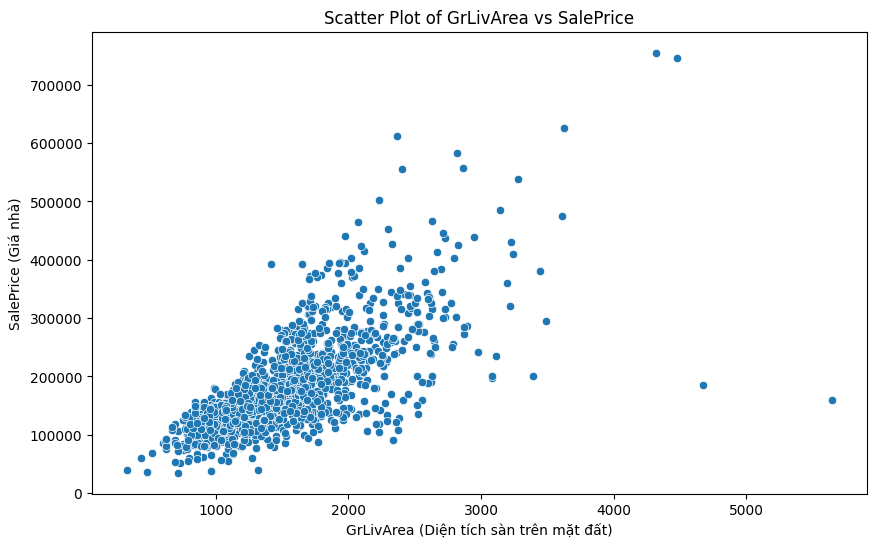

In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'])
plt.title('Scatter Plot of GrLivArea vs SalePrice')
plt.xlabel('GrLivArea (Diện tích sàn trên mặt đất)')
plt.ylabel('SalePrice (Giá nhà)')
plt.show()

Có vài điểm nằm ngoài xu hướng đám đông --> phải loại bỏ chúng

Vì mô hình RF tốt hơn nên ta dùng mô hình đó để làm tiếp

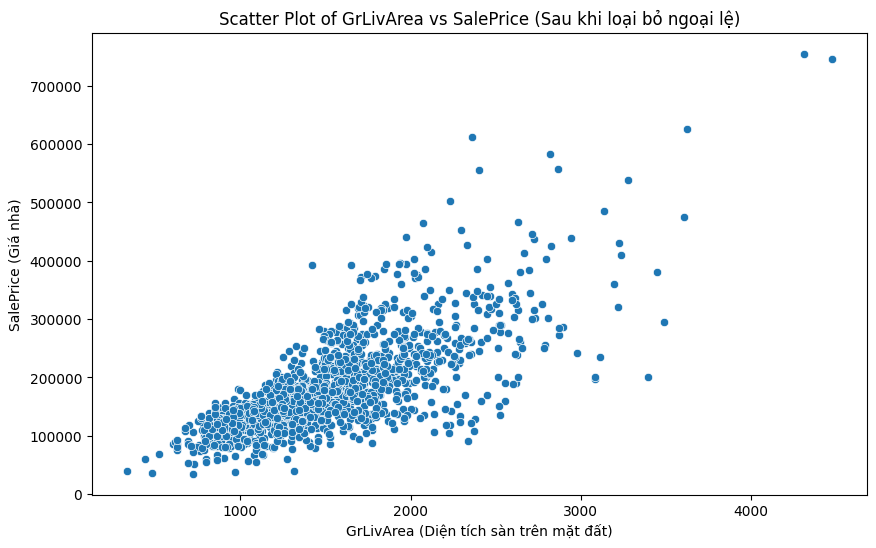


Hiệu suất của mô hình Random Forest Regressor trên tập kiểm tra (sau khi xử lý ngoại lệ):
Mean Squared Error (MSE): 587752135.36
Root Mean Squared Error (RMSE): 24243.60
R-squared (R²): 0.89


In [58]:
# Xác định các ngoại lệ dựa trên ngưỡng
outliers = df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)].index

# Loại bỏ các ngoại lệ khỏi DataFrame
df = df.drop(outliers)

# Vẽ lại scatter plot sau khi loại bỏ ngoại lệ để kiểm tra
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'])
plt.title('Scatter Plot of GrLivArea vs SalePrice (Sau khi loại bỏ ngoại lệ)')
plt.xlabel('GrLivArea (Diện tích sàn trên mặt đất)')
plt.ylabel('SalePrice (Giá nhà)')
plt.show()

# Chia lại dữ liệu thành tập huấn luyện và tập kiểm tra sau khi loại bỏ ngoại lệ
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện lại mô hình Random Forest Regressor trên dữ liệu đã được làm sạch
rf_model_cleaned = RandomForestRegressor(random_state=42)
rf_model_cleaned.fit(X_train, y_train)

# Dự đoán và đánh giá lại mô hình
y_pred_rf_cleaned = rf_model_cleaned.predict(X_test)
mse_rf_cleaned = mean_squared_error(y_test, y_pred_rf_cleaned)
rmse_rf_cleaned = np.sqrt(mse_rf_cleaned)
r2_rf_cleaned = r2_score(y_test, y_pred_rf_cleaned)

print("\nHiệu suất của mô hình Random Forest Regressor trên tập kiểm tra (sau khi xử lý ngoại lệ):")
print(f"Mean Squared Error (MSE): {mse_rf_cleaned:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_cleaned:.2f}")
print(f"R-squared (R²): {r2_rf_cleaned:.2f}")

### Hyperparameter Tuning
Tối ưu hoá mô hình RF bằng cách dùng Cross_validation

In [59]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa lưới các siêu tham số để tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Khởi tạo mô hình Random Forest Regressor
rf_model_tune = RandomForestRegressor(random_state=42)

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(estimator=rf_model_tune,
                           param_grid=param_grid,
                           cv=3,  # Sử dụng 3-fold cross-validation
                           scoring='neg_mean_squared_error',  # Metric để đánh giá
                           n_jobs=-1)  # Sử dụng tất cả các core CPU có sẵn

# Thực hiện tìm kiếm trên lưới
grid_search.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất
print("Các siêu tham số tốt nhất tìm thấy:")
print(grid_search.best_params_)

# Lấy mô hình tốt nhất
best_rf_model = grid_search.best_estimator_

# Dự đoán và đánh giá mô hình tốt nhất trên tập kiểm tra
y_pred_best_rf = best_rf_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\nHiệu suất của mô hình Random Forest Regressor tốt nhất trên tập kiểm tra:")
print(f"Mean Squared Error (MSE): {mse_best_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_best_rf:.2f}")
print(f"R-squared (R²): {r2_best_rf:.2f}")

Các siêu tham số tốt nhất tìm thấy:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Hiệu suất của mô hình Random Forest Regressor tốt nhất trên tập kiểm tra:
Mean Squared Error (MSE): 569273680.31
Root Mean Squared Error (RMSE): 23859.46
R-squared (R²): 0.90


Thời gian cpu chạy huấn luyện 3p29s

--> Hiệu suất tăng lên 90%, MSE và RMSE giảm